In [1]:
# pip install tensorflow==2.13

In [2]:
# pip install matplotlib

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size = (IMAGE_SIZE , IMAGE_SIZE),   
    batch_size = BATCH_SIZE 
)

Found 2152 files belonging to 3 classes.


In [6]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset) # Number of batches in the dataset = 32 * 68 

68

In [8]:
for images, labels in dataset.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 256, 256, 3)
[0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0]


(-0.5, 255.5, 255.5, -0.5)

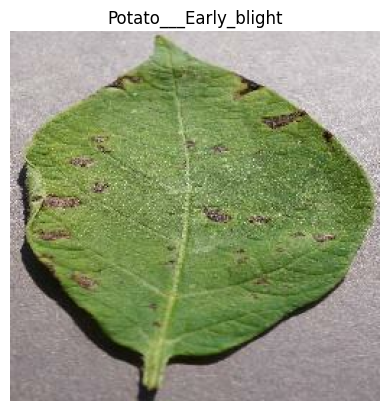

In [9]:
plt.imshow(images[0].numpy().astype("uint8"))
plt.title(class_name[labels[0]])
plt.axis('off')

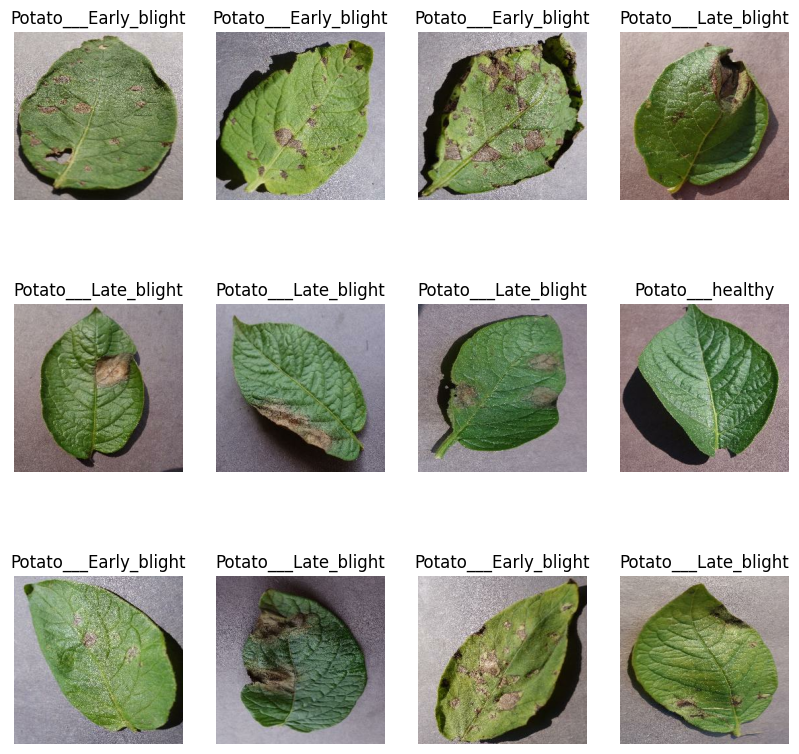

In [10]:
for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(12):
        ax = plt.subplot(3,4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_name[labels[i]])
        plt.axis("off")

In [11]:
# 80% of the dataset for training
# 10% of the dataset for validation 
# 10% of the dataset for testing
training_size = len(dataset) *0.8
training_dataset = dataset.take(int(training_size))
len(training_dataset), training_size


(54, 54.400000000000006)

In [12]:
validation_size = len(dataset) *0.1
validation_dataset = dataset.skip(int(training_size)).take(int(validation_size))
len(validation_dataset)

6

In [13]:
testing_dataset = dataset.skip(int(training_size + validation_size))
len(testing_dataset)

7

In [14]:
# summerize with functions (mine)
def split_dataset(dataset = dataset, training_ratio=0.8, validation_ratio=0.1, testing_ratio=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    training_dataset = dataset.take(int(ds_size * training_ratio))
    validation_dataset = dataset.skip(int(ds_size * training_ratio)).take(int(ds_size * validation_ratio))
    testing_dataset = dataset.skip(int(ds_size * training_ratio) + int(ds_size * validation_ratio))
    return training_dataset, validation_dataset, testing_dataset

In [15]:
training_dataset, validation_dataset, testing_dataset = split_dataset(dataset)

In [16]:
# summerize with functions (dhwal)
# def split_dataset1(dataset, training_ratio=0.8, validation_ratio=0.1, testing_ratio=0.1, shuffle=True, shuffle_size=10000):
#     ds_size = len(dataset)
#     if shuffle:
#         dataset = dataset.shuffle(shuffle_size, seed=12)
#     train_size = int(ds_size * training_ratio)
#     val_size = int(ds_size * validation_ratio)
    
#     train_ds = dataset.take(train_size)
#     val_ds = dataset.skip(train_size).take(val_size)
#     test_ds = dataset.skip(train_size + val_size)
#     return len(train_ds), len(val_ds), len(test_ds)
# split_dataset1(dataset = dataset)

cache() stores the dataset in memory (or optionally on disk) after it's loaded once, so it doesn't reload or reprocess the data from the source (like disk, file parsing, or transformation) for every epoch.

🔹 Useful when your dataset fits in memory

🔹 Greatly improves performance in multi-epoch training

-----------

prefetch(buffer_size=N) allows the input pipeline to fetch and prepare the next batch in the background while the model is training on the current batch, reducing idle time and improving GPU/CPU utilization.

🔹 tf.data.AUTOTUNE automatically picks the optimal buffer size based on available system resources

In [17]:
training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testing_dataset = testing_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')  
])

model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [22]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(training_dataset,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=1,
          validation_data=validation_dataset)

Epoch 1/50
54/54 [==============================] - 97s 2s/step - loss: 0.7149 - accuracy: 0.6626 - val_loss: 0.4103 - val_accuracy: 0.8646
Epoch 2/50
54/54 [==============================] - 92s 2s/step - loss: 0.3612 - accuracy: 0.8582 - val_loss: 0.3190 - val_accuracy: 0.8802
Epoch 3/50
54/54 [==============================] - 89s 2s/step - loss: 0.2555 - accuracy: 0.9034 - val_loss: 0.2318 - val_accuracy: 0.9323
Epoch 4/50
54/54 [==============================] - 89s 2s/step - loss: 0.2755 - accuracy: 0.8981 - val_loss: 0.3225 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 100s 2s/step - loss: 0.2317 - accuracy: 0.9132 - val_loss: 0.2947 - val_accuracy: 0.8698
Epoch 6/50
54/54 [==============================] - 98s 2s/step - loss: 0.1721 - accuracy: 0.9352 - val_loss: 0.2117 - val_accuracy: 0.9115
Epoch 7/50
54/54 [==============================] - 94s 2s/step - loss: 0.1696 - accuracy: 0.9358 - val_loss: 0.1185 - val_accuracy: 0.9531
Epoch 8/50
54/54 [=

In [24]:
score = model.evaluate(testing_dataset)

8/8 [==============================] - 4s 278ms/step - loss: 0.0527 - accuracy: 0.9883


In [25]:
score

[0.0527372732758522, 0.98828125]

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']



Text(0.5, 1.0, 'training and validation loss')

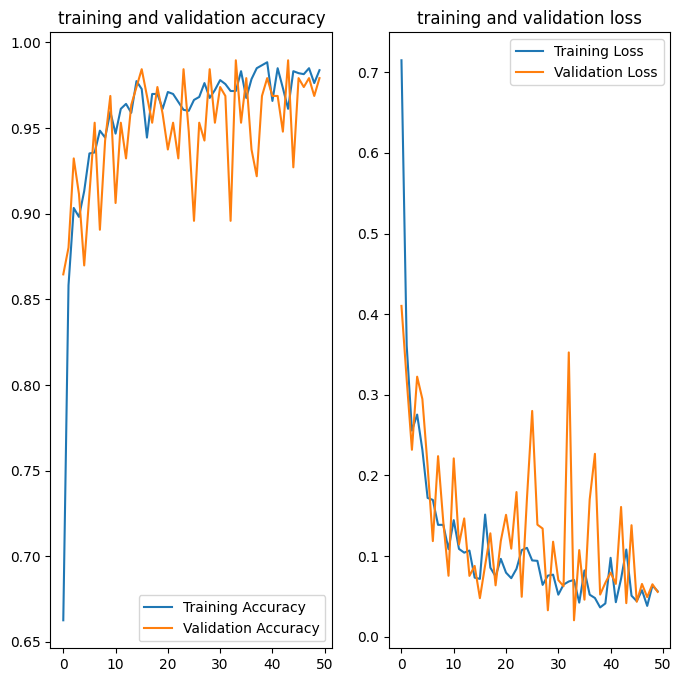

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('training and validation loss')

In [38]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


first image to predict
actual label :  Potato___Late_blight
1/1 [==============================] - 0s 266ms/step
Potato___Late_blight


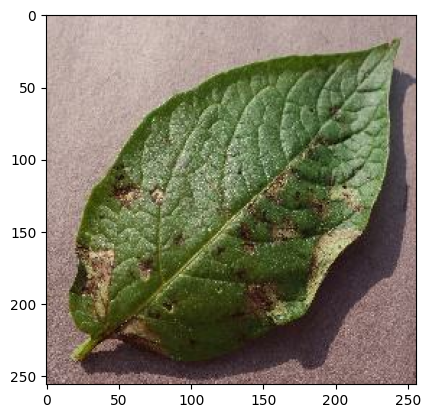

In [44]:
import numpy as np
for image_batch, labels_batch in testing_dataset.take(1):

    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label : ", class_name[first_label])

    batch_prediction = model.predict(image_batch)
    print(class_name[np.argmax(batch_prediction[0])])

In [48]:
import os
print(os.getcwd())

C:\Users\yashg\Desktop\sain_DL_potatodisease


In [49]:
model_version = 1
model.save(f"C:/Users/yashg/Desktop/sain_DL_potatodisease/models/{model_version}")

INFO:tensorflow:Assets written to: C:/Users/yashg/Desktop/sain_DL_potatodisease/models/1\assets


INFO:tensorflow:Assets written to: C:/Users/yashg/Desktop/sain_DL_potatodisease/models/1\assets


In [61]:
import os
model_version = max([int(i) for i in os.listdir("C:/Users/yashg/Desktop/sain_DL_potatodisease/models") + [0]]) + 1
print(model_version)
model.save(f"C:/Users/yashg/Desktop/sain_DL_potatodisease/models/{model_version}")

10
INFO:tensorflow:Assets written to: C:/Users/yashg/Desktop/sain_DL_potatodisease/models/10\assets


INFO:tensorflow:Assets written to: C:/Users/yashg/Desktop/sain_DL_potatodisease/models/10\assets
